# 📚 Libraries


In [1]:
import torch
import spacy
import numpy as np
import transformers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim
from collections import defaultdict
from zenml.environment import Environment
from huggingface_hub import notebook_login
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from transformers.modeling_utils import PreTrainedModel
from sklearn.metrics import classification_report, confusion_matrix

from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoConfig,
    get_linear_schedule_with_warmup,
)

# 🥼 Google Colab


In [2]:
if Environment.in_google_colab():
    print(f"🥼 Running on Google Colab")

    from google.colab import drive

    drive.mount("/content/drive")

    data_path = (
        "/content/drive/My Drive/Colab Notebooks/Natural Language Processing/Project"
    )
else:
    data_path = "./"

# 🧑‍💻 CUDA Specification


In [3]:
from torch import cuda

device = "cuda" if cuda.is_available() else "cpu"

# 🧘‍♂️ ZenML


In [4]:
# Environment

# 📚 Import Data


In [5]:
df_train = pd.read_csv(f"{data_path}/data/train_clean.csv.zip")
# df_val = pd.read_csv(f"{data_path}/data/val_clean.csv.zip")
df_test = pd.read_csv(f"{data_path}/data/test_clean.csv.zip")

In [6]:
print(f"🏃‍♂️ Train shape: {df_train.shape}")
# print(f"🏋️ Validation shape: {df_val.shape}")
print(f"🧐 Test shape: {df_test.shape}")

🏃‍♂️ Train shape: (5600, 15)
🧐 Test shape: (2400, 15)


## 📖 Define the data


In [7]:
MODEL_NAME = "bert-base-uncased"
SPACY_MODEL = "en_core_web_sm"

In [8]:
GENRE_MAPPING = {"pop": 0, "rap": 1, "rock": 2, "r&b": 3, "edm": 4}

In [9]:
AUDIO_FEATURES = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "valence",
]

In [10]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-05

# 🧩 Tokenizer


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 🧠 Preprocessing


In [12]:
class LyricsAudioDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.scaler = StandardScaler()
        self.data = dataframe
        self.lyrics = dataframe.lyrics
        self.audio = self.scaler.fit_transform(dataframe[AUDIO_FEATURES])
        self.targets = self.data.playlist_genre_id
        self.max_len = max_len

        # Load Spacy model for text preprocessing
        self.nlp = spacy.load(SPACY_MODEL, disable=["parser", "ner"])

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, index):
        lyrics = self._preprocess_lyrics(str(self.lyrics[index]))

        inputs = self.tokenizer.encode_plus(
            lyrics,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
        )

        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "audio": torch.tensor(self.audio[index], dtype=torch.float),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

    def _preprocess_lyrics(self, text):
        doc = self.nlp(text)
        processed_text = " ".join(
            [
                token.lemma_.lower().strip()
                for token in doc
                if not token.is_stop and token.lemma_.isalpha() and not token.is_punct
            ]
        )
        return processed_text

In [13]:
training_set = LyricsAudioDataset(df_train, tokenizer, MAX_LEN)
# validation_set = LyricsAudioDataset(df_val, tokenizer, MAX_LEN)
testing_set = LyricsAudioDataset(df_test, tokenizer, MAX_LEN)

In [14]:
train_params = {"batch_size": TRAIN_BATCH_SIZE, "shuffle": True, "num_workers": 0}
# val_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": True, "num_workers": 0}
test_params = {"batch_size": VALID_BATCH_SIZE, "shuffle": False, "num_workers": 0}

training_loader = DataLoader(training_set, **train_params)
# validation_loader = DataLoader(validation_set, **val_params)
testing_loader = DataLoader(testing_set, **test_params)

# 📐 Modeling


In [15]:
class LyricsAudioModel(PreTrainedModel):
    def __init__(self, config, num_labels=5):
        super(LyricsAudioModel, self).__init__(config=config)
        self.num_labels = num_labels

        # BERT Model
        self.l1 = AutoModel.from_pretrained(MODEL_NAME, config=config)

        # Audio MLP
        self.audio_mlp = nn.Sequential(
            nn.Linear(len(AUDIO_FEATURES), config.hidden_size),
            nn.BatchNorm1d(config.hidden_size),
            nn.ReLU(),
            nn.Dropout(config.hidden_dropout_prob),
        )

        # Classifier Head
        self.pre_classifier = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.batch_norm = nn.BatchNorm1d(config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, audio=None
    ) -> torch.Tensor:
        # BERT Forward Pass
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1.last_hidden_state
        pooler = hidden_state[:, 0]

        # Audio MLP Forward Pass
        audio_out = self.audio_mlp(audio)

        # Early Fusion
        pooler = torch.cat((pooler, audio_out), 1)

        # Classifier Head
        pooler = self.pre_classifier(pooler)
        pooler = self.batch_norm(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)

        logits = self.classifier(pooler)
        return logits

    def freeze_bert_encoder(self):
        for param in self.l1.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.l1.parameters():
            param.requires_grad = True

In [16]:
model = LyricsAudioModel(
    AutoConfig.from_pretrained(MODEL_NAME), num_labels=len(GENRE_MAPPING)
)
model.to(device)

LyricsAudioModel(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [17]:
loss_function = nn.CrossEntropyLoss(
    weight=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device)
)


optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=0.005)

num_warmup_steps = len(training_loader) * EPOCHS * 0.1
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(training_loader) * EPOCHS,
)

In [18]:
def calculate_accuracy(big_idx, targets):
    n_correct = (big_idx == targets).sum().item()
    return n_correct

## 🧪 Training


In [19]:
def train(epoch, model, train_loader, loss_function, optimizer, device):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    model.train()

    print(f"🏃‍♂️ Training Epoch: {epoch + 1}")

    for _, batch in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        input_ids = batch["input_ids"].to(device, dtype=torch.long)
        attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
        audio_features = batch["audio"].to(device, dtype=torch.float)
        targets = batch["targets"].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
        loss = loss_function(outputs, targets)
        total_loss += loss.item()

        # Calculate and accumulate correct predictions
        _, predictions = torch.max(outputs.data, dim=1)
        correct_predictions += (predictions == targets).sum().item()

        total_samples += targets.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update the learning rate
        scheduler.step(correct_predictions)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Training Epoch {epoch + 1} Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 📈 Evaluation


In [20]:
def evaluate(model, eval_loader, loss_function, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    print(f"🧐 Evaluating Model...")

    with torch.no_grad():
        for _, batch in tqdm(enumerate(eval_loader, 0), total=len(eval_loader)):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Calculate and accumulate correct predictions
            _, predictions = torch.max(outputs.data, dim=1)
            correct_predictions += (predictions == targets).sum().item()

            total_samples += targets.size(0)

    epoch_loss = total_loss / len(eval_loader)
    epoch_accuracy = (correct_predictions / total_samples) * 100

    print(
        f"🏁 Evaluation Complete | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%\n"
    )

    return epoch_loss, epoch_accuracy

## 🥧 Complie


In [21]:
history = defaultdict(list)
best_accuracy = 0

best_validation_loss = float("inf")

for epoch in range(EPOCHS):
    # Training
    train_loss, train_accuracy = train(
        epoch, model, training_loader, loss_function, optimizer, device
    )
    # Validation
    # validation_loss, validation_accuracy = evaluate(
    #     model, validation_loader, loss_function, device
    # )
    validation_loss, validation_accuracy = evaluate(
        model, testing_loader, loss_function, device
    )

    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy

    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["validation_loss"].append(validation_loss)
    history["validation_accuracy"].append(validation_accuracy)

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        model.save_pretrained(f"{data_path}/model")
        tokenizer.save_pretrained(f"{data_path}/model")
        print(f"🎉 Model saved at epoch {epoch + 1}")
    else:
        print("🚨 Early stopping! Validation loss hasn't improved. Stopping training.")
        break

print(f"🎯 Training complete!")
print(f"🏆 Best Validation Accuracy: {best_accuracy:.2f}%")

🏃‍♂️ Training Epoch: 1


100%|██████████| 350/350 [07:59<00:00,  1.37s/it]


🏁 Training Epoch 1 Complete | Loss: 1.3124 | Accuracy: 45.45%

🧐 Evaluating Model...


100%|██████████| 150/150 [02:04<00:00,  1.21it/s]


🏁 Evaluation Complete | Loss: 1.1093 | Accuracy: 58.13%

🎉 Model saved at epoch 1
🏃‍♂️ Training Epoch: 2


100%|██████████| 350/350 [07:36<00:00,  1.30s/it]


🏁 Training Epoch 2 Complete | Loss: 1.0869 | Accuracy: 58.18%

🧐 Evaluating Model...


100%|██████████| 150/150 [02:28<00:00,  1.01it/s]


🏁 Evaluation Complete | Loss: 1.0198 | Accuracy: 59.67%

🎉 Model saved at epoch 2
🏃‍♂️ Training Epoch: 3


100%|██████████| 350/350 [07:57<00:00,  1.36s/it]


🏁 Training Epoch 3 Complete | Loss: 1.0139 | Accuracy: 61.62%

🧐 Evaluating Model...


100%|██████████| 150/150 [01:58<00:00,  1.27it/s]


🏁 Evaluation Complete | Loss: 0.9683 | Accuracy: 62.29%

🎉 Model saved at epoch 3
🏃‍♂️ Training Epoch: 4


100%|██████████| 350/350 [07:18<00:00,  1.25s/it]


🏁 Training Epoch 4 Complete | Loss: 0.9634 | Accuracy: 63.36%

🧐 Evaluating Model...


100%|██████████| 150/150 [02:02<00:00,  1.22it/s]


🏁 Evaluation Complete | Loss: 0.9416 | Accuracy: 59.40%

🎉 Model saved at epoch 4
🏃‍♂️ Training Epoch: 5


100%|██████████| 350/350 [07:23<00:00,  1.27s/it]


🏁 Training Epoch 5 Complete | Loss: 0.9201 | Accuracy: 65.34%

🧐 Evaluating Model...


100%|██████████| 150/150 [02:18<00:00,  1.09it/s]


🏁 Evaluation Complete | Loss: 0.9297 | Accuracy: 59.00%

🎉 Model saved at epoch 5
🎯 Training complete!
🏆 Best Validation Accuracy: 59.40%


# 😵 Report


In [22]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for _, batch in tqdm(
            enumerate(data_loader, 0), total=len(data_loader), desc="Predicting"
        ):
            input_ids = batch["input_ids"].to(device, dtype=torch.long)
            attention_mask = batch["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            audio_features = batch["audio"].to(device, dtype=torch.float)
            targets = batch["targets"].to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids, audio_features)
            _, preds = torch.max(outputs, dim=1)

            predictions.append(preds)
            real_values.append(targets)

    predictions = torch.cat(predictions).cpu()
    real_values = torch.cat(real_values).cpu()

    return predictions, real_values

In [23]:
predictions, real_values = get_predictions(model, testing_loader)
report = classification_report(
    real_values, predictions, target_names=GENRE_MAPPING.keys(), output_dict=True
)

print("📊 Classification Report")
print(
    classification_report(real_values, predictions, target_names=GENRE_MAPPING.keys())
)

Predicting: 100%|██████████| 150/150 [02:05<00:00,  1.20it/s]

📊 Classification Report
              precision    recall  f1-score   support

         pop       0.49      0.39      0.43       480
         rap       0.77      0.82      0.80       480
        rock       0.62      0.70      0.66       480
         r&b       0.63      0.52      0.57       480
         edm       0.60      0.73      0.66       480

    accuracy                           0.59      2400
   macro avg       0.59      0.63      0.59      2400
weighted avg       0.62      0.63      0.58      2400



In [24]:
print(f"📊 Save Classification Report")
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{data_path}/report/classification_report.csv", index=False)

📊 Save Classification Report


# 📊 Visualization


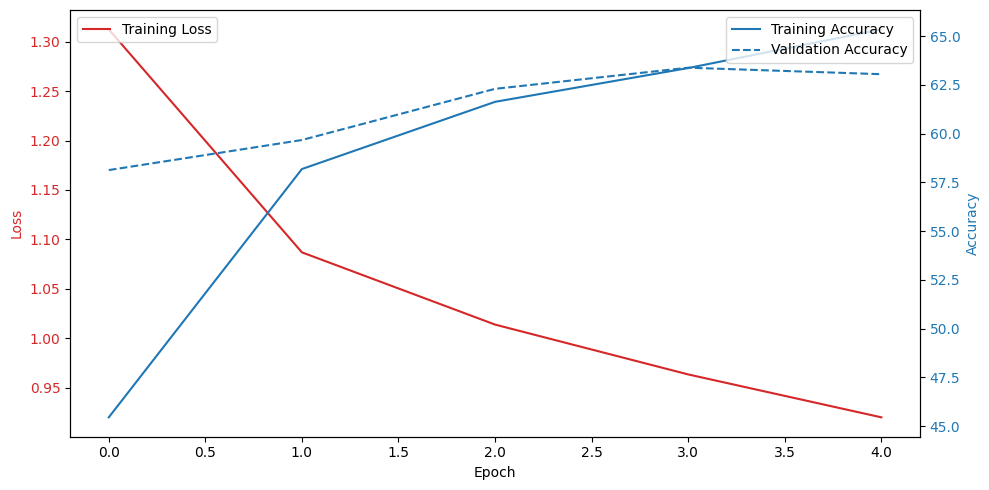

In [25]:
def plot_metrics(train_losses, train_accuracies, validation_accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(train_losses, label="Training Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")

    ax2.plot(train_accuracies, label="Training Accuracy", color="tab:blue")
    ax2.plot(
        validation_accuracies,
        label="Validation Accuracy",
        linestyle="--",
        color="tab:blue",
    )
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()
    fig.savefig(f"{data_path}/report/metrics.png")


plot_metrics(
    history["train_loss"],
    history["train_accuracy"],
    history["validation_accuracy"],
)

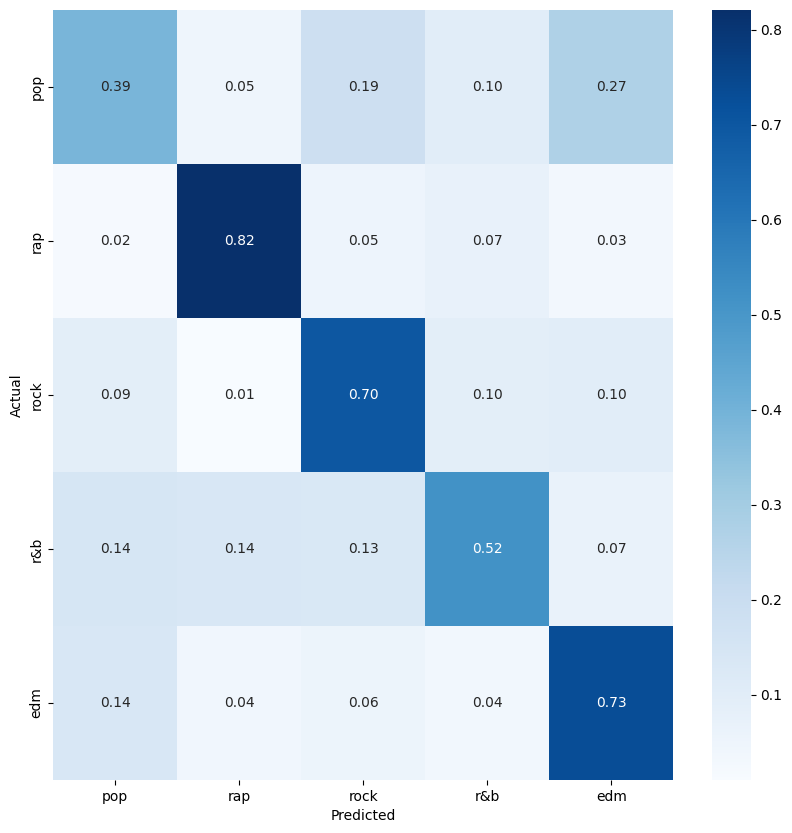

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    fig.savefig(f"{data_path}/report/confusion_matrix.png")


plot_confusion_matrix(
    real_values,
    predictions,
    classes=GENRE_MAPPING.keys(),
)

# ☁️ Upload to Hugging Face


In [27]:
if history["validation_accuracy"][-1] > 60.0:
    repository_name = "PunGrumpy/music-genre-classification"

    config = AutoConfig.from_pretrained(MODEL_NAME)

    model.push_to_hub(repository_name, token=True, branch="main", config=config)
    tokenizer.push_to_hub(repository_name, token=True)
    print(f"Model pushed to {repository_name}")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

c:\Users\grumpy\anaconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\grumpy\.cache\huggingface\hub\models--PunGrumpy--music-genre-classification. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Model pushed to PunGrumpy/music-genre-classification
